In [1]:
# test_imports in this cell, restart kernel whenever edits to modules are made

import sys
import os
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

#import config based on which machine the jupyter notebook is running on
from configs.config_local import *
from preprocessing import *
from module_detection import *
from postprocessing import *
from utils import *

def test_imports():
    print("testing config class")
    config = Config()
    print(config)

    print("testing 2d contacts preprocessing classes")
    query = HiCQuery(config, 'chr1', 1000000, '1Mb') #needs config, chrom and res/res0 for instantiation
    print(query)

    
    #other prints for imported classes

test_imports()

testing config class
testing 2d contacts preprocessing classes
HiC file loaded


## OE part of the pipeline

In [3]:
#initialising parameters for single chromosome analysis

config = Config()
chrom = config.genomic_params.chromosomes[0]
current_res = config.genomic_params.resolutions[0]  # 1Mb for OE part
current_res_str = config.genomic_params.res_strs[0]  # 1Mb for OE part
query = HiCQuery(config, chrom, current_res, current_res_str)

HiC file loaded


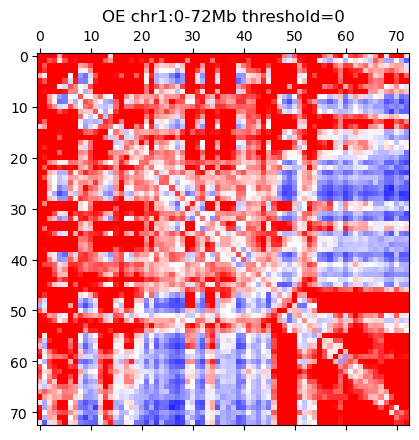

In [4]:
## TRYING DIFFERENT THRESHOLDS ##

# params for OE matrix visualisation
threshold = 0
start = 0
end = 72000000
# Directory to save plots
output_dir = os.path.join(config.paths.temp_dir, f"oe_plots_{threshold}")
os.makedirs(output_dir, exist_ok=True)

# Custom colormap
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])

## single chr visualisation ##
oe_numpy_thresholded = query.oe_intra_numpy(start, end, threshold)
region_str = format_loci_string(start, end, current_res_str) 

def plot_single_hic_map(dense_matrix, cmap, vmin=0, vmax=30, title=""):
    d2 = dense_matrix
    d2[np.isnan(d2)] = 0
    d2[np.isinf(d2)] = 0
    plt.matshow(dense_matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.show()

plot_single_hic_map(oe_numpy_thresholded, 'bwr', 0, 1, f"OE {chrom}:{region_str} threshold={threshold}")

#run multiprocessing in python script (.ipynb runs give errors)

In [5]:
## Get AB score of the intra-chr OE matrix ##
oe_intra_csr = query.oe_straw_to_csr()
ab_score_intra = query.ab_comp.calculate_ab_score(oe_intra_csr) #send sparse matrix to calculate whole chr ab_score
print(ab_score_intra)


Filename: /Users/Akanksha/MaGroup/Genomic Hubs/3D_chromatin_hubs/src/preprocessing/hic_data_loader.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   139    244.7 MiB    244.7 MiB           1       @profile
   140                                             def oe_intra(self, threshold=0):
   141                                                 """
   142                                                 returns contact records for one chromosome as straw object, thresholded if needed
   143                                                 straw object : .binX [0] .binY [1] .counts [2] as attributes of list
   144                                                 """
   145    244.7 MiB      0.0 MiB           1           chrom = self.chrom[3:]
   146    244.7 MiB      0.0 MiB           1           res = int(self.res)
   147    247.6 MiB      2.9 MiB           2           oe_list = hicstraw.straw(
   148    244.7 MiB      0.0 MiB           1               "oe", self.hic_norm

In [13]:
## Plot AB score with hic oe to see if +:A and -:B strategy is good or not##

def plot_2dhic_1dtrack_map(dense_matrix, signal, vmin, vmax, cmap):
  d2 = dense_matrix # np.log(dense_matrix)
  d2[np.isnan(d2)] = 0
  d2[np.isinf(d2)] = 0
  fig = plt.figure()
  fig.set_figheight(12)
  fig.set_figwidth(8)
  spec = gridspec.GridSpec(ncols=1, nrows=2,
                         width_ratios=[1], wspace=1,
                         hspace=.1, height_ratios=[16, 30])
  ax0 = fig.add_subplot(spec[0])
  ax0.plot(np.arange(len(signal)), signal)
  ax1 = fig.add_subplot(spec[1])
  ax1.matshow(d2, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()


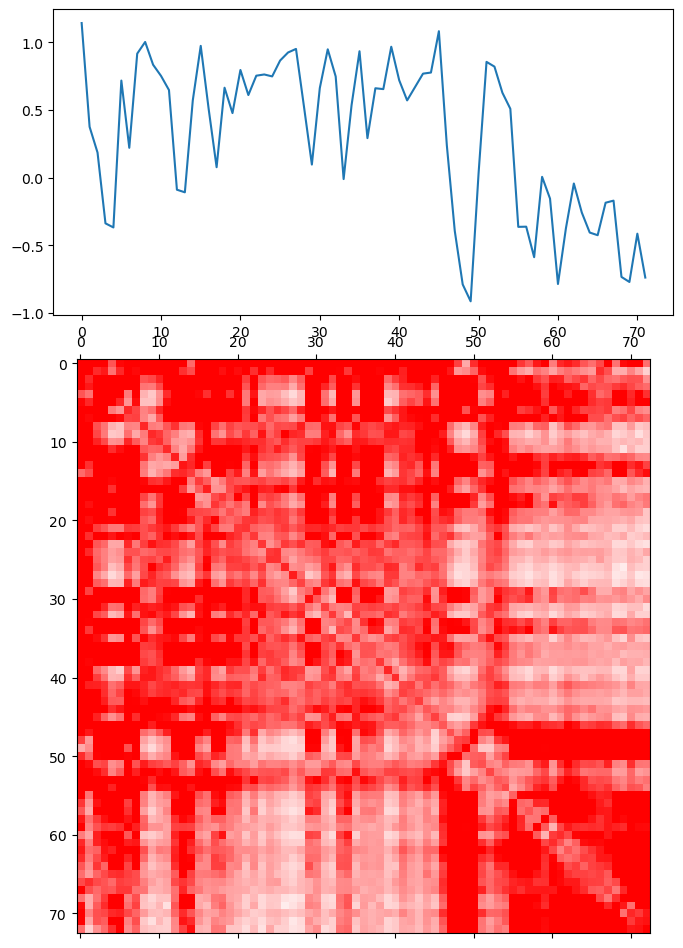

In [15]:
plot_2dhic_1dtrack_map(oe_numpy_thresholded, filtered_signal, 0, 1, REDMAP)

HiC file loaded


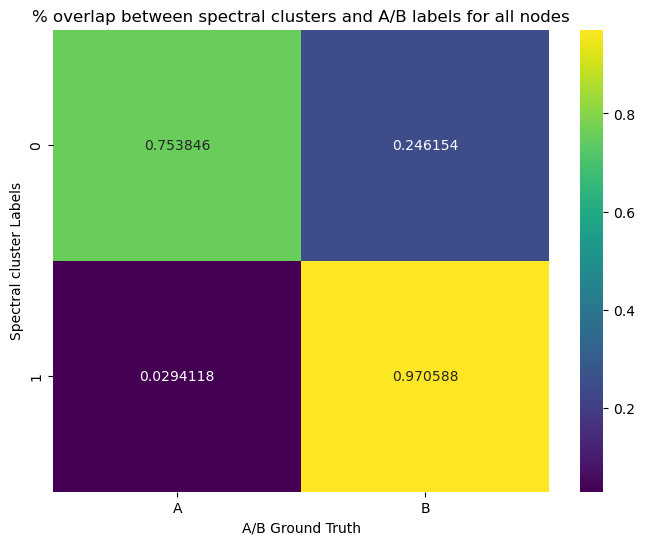

In [7]:
## plot confusion matrix between cluster labels and ab scores ##

def plot_confusion_matrix_heatmap(confusion_matrix):
    """
    Plot the confusion matrix as a heatmap.

    Parameters:
    confusion_matrix (numpy.ndarray): A 2x2 confusion matrix.
    """
    #normalize the confusion matirx
    cnf_mtx_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    gt_labels = ['A', 'B']
    cluster_labels = ['0', '1']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cnf_mtx_norm, annot=True, fmt='g', cmap='viridis', xticklabels=gt_labels, yticklabels=cluster_labels)
    plt.xlabel('A/B Ground Truth')
    plt.ylabel('Spectral cluster Labels')
    plt.title('% overlap between spectral clusters and A/B labels for all nodes')
    plt.show()

config = Config()
conf_matx = single_chrom_clustering("chr1", config, 1000000, "1Mb")
plot_confusion_matrix_heatmap(conf_matx)

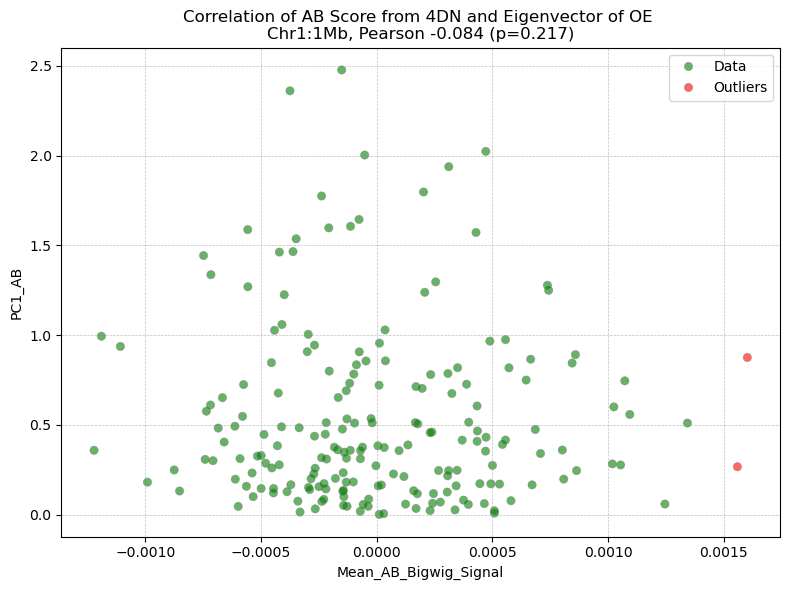

In [6]:
## plot correlation between calculated ab scores and geo ab scores ##

# Sample data
# Replace this with your actual data loading step
data = pd.DataFrame({
    'Mean_AB_Bigwig_Signal': np.random.normal(0, 0.0005, 200),
    'PC1_AB': np.random.exponential(0.5, 200)
})

# Identifying outliers for demonstration
data['Outliers'] = (data['PC1_AB'] > 3) | (data['Mean_AB_Bigwig_Signal'].abs() > 0.0015)

# Scatter plot using seaborn
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=data, 
    x='Mean_AB_Bigwig_Signal', 
    y='PC1_AB', 
    hue='Outliers', 
    palette={False: 'green', True: 'red'}, 
    legend='full',
    edgecolor='grey',  # Grey borders
    alpha=0.6
)
#add grid dashed lines with low opacity
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Adding legend
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles=handles, labels=['Data', 'Outliers'])

# Title and labels
plt.title('Correlation of AB Score from 4DN and Eigenvector of OE \nChr1:1Mb, Pearson -0.084 (p=0.217)') #correlation and significance of number
plt.xlabel('Mean_AB_Bigwig_Signal') #gt
plt.ylabel('PC1_AB') #calculated

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
## plot cluster_size split between A and B 